In [ ]:
import sys
import os
# ROOT_DIR=os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
ROOT_DIR=r'C:\Users\logan\Desktop\MEng\Mask_RCNN'
sys.path.append(ROOT_DIR)


import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import math

# load the class label names from disk, one label per line
# CLASS_NAMES = open("coco_labels.txt").read().strip().split("\n")

# ROOT_DIR=os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
CLASS_NAMES = ['BG', 'Ice','Ship']
TestDir="\\IceData\\test_imgs\\"
# TestDir="\\IceData\\stage1_save\\"
TrainedWeights=ROOT_DIR+"\\mask_rcnn_iceshiptf1config_0050.h5"

class SimpleConfig(mrcnn.config.Config):
    # Give the configuration a recognizable name
    NAME = "Ice_ship_interference"
    
    # set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

	# Number of classes = number of classes + 1 (+1 for the background). The background class is named BG
    NUM_CLASSES = len(CLASS_NAMES)

# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

# Load the weights into the model.
model.load_weights(filepath=TrainedWeights, 
                   by_name=True)

# load the input image, convert it from BGR to RGB channel
Test_Dir=os.listdir(ROOT_DIR+ TestDir) #lists the kangaroo test image dir
randomImg=Test_Dir[random.randint(0,len(Test_Dir)-1)]
image = cv2.imread(ROOT_DIR+TestDir+randomImg) #picks a random image in the kangaroo test image dir.
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform a forward pass of the network to obtain the results
r = model.detect([image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
# print('Chosen random file to display with mask predictions: ',randomImg)

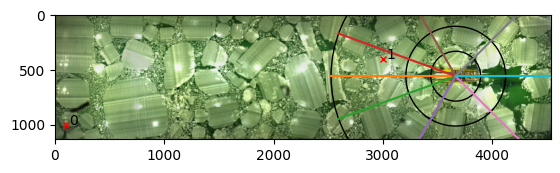

In [22]:
def getCentroid(mask,GetShipLength=False):
    #m is one mask
    ##get xy coordinates of each item, then avg them
    horiz = np.where(np.any(mask, axis=0))[0]
    verti = np.where(np.any(mask, axis=1))[0]
    
    hori_mean=np.mean(horiz)
    verti_mean=np.mean(verti)
    
    output=[hori_mean,verti_mean]
    
    if GetShipLength:
        #this gets length of the mask- can be used to get shiplength with zero yaw
        hmax,hmin = horiz[[0, -1]]
        ShipL=abs(hmax-hmin) #shiplength in px
        output.append(ShipL)

    return output

def addlines(plt,radius,angleIncrement,center,equalangles=True):
    ##if equalangles is true then angle increment should be an integer, otherwise
    angles=[]
    if equalangles: 
        if isinstance(angleIncrement, float):
            print("angle increment should be integer")
            exit()
        for n in range(1,round(360/angleIncrement)):
            angles.append(n*math.radians(angleIncrement))
    
    if not equalangles:
        for deg in angleIncrement: 
            angles.append(math.radians(deg))
            angles.append(math.radians(-deg))
    
    for angle in angles: 
        plt.plot([center[0],center[0]-radius*math.cos(angle)],[center[1],center[1]+radius*math.sin(angle)])

def viz_centroids(image,centroidlist,r,ShowCentroids=True,ShowRegions=True):
    import matplotlib.pyplot as plt
    import pylab
    plt.imshow(image)
    
    masks=r['masks']
    classes=r['class_ids']
    
    shipIndex=np.where(classes==CLASS_NAMES.index('Ship'))[0]
    shipx,shipy,ShipLength=getCentroid(masks[:, :, shipIndex[0]][:, :, np.newaxis],GetShipLength=True)
    
    if ShowCentroids:
        for i in centroidlist: 
            n=centroidlist.index(i)
            plt.plot(i[0],i[1],'rx',markersize=5)
            pylab.text(i[0]+30,i[1],n)
    
    if ShowRegions:
        radii=[0.5,1,2.5]
        for radius in radii:
            plt.gca().add_patch(plt.Circle((shipx,shipy), radius*ShipLength, color='black', fill=False))

        addlines(plt,radius=2.5*ShipLength,equalangles=False,angleIncrement=[0,20,60,135,180],center=[shipx,shipy])
        plt.xlim(0, image.shape[1])
        plt.ylim(image.shape[0],0)
        

    plt.show()

viz_centroids(image,[[100,1000],[3000,400]],r,ShowCentroids=True,ShowRegions=True)

In [4]:
for i in range(0,5): 
    if i==3: 
        continue
    beans=range(40,66)
    g=[]
    for b in beans:
        g.append(b)
    print(g)
    print("VAL IS",i)


[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
VAL IS 0
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
VAL IS 1
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
VAL IS 2
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
VAL IS 4


In [ ]:
angle=math.degrees(math.atan2(1,-1))

print(angle)

In [ ]:
#####this is learning howto drop +1 into correct category.
ShipLength=100
RegionDefinition={"Radii":[0.5*ShipLength,1*ShipLength,2.5*ShipLength],"AngleIncrements":[20,60,135,180]} #do NOT explicitly say 0 degrees.    
# Initialize dictionary of the regions; these will be filled in later with sub-dictionaries that have the "index-class" of the detection we found
regionStats={}
prevRadi=0
prevAngl=0
regionStats["Centroids"]=[] #empty list, eventually will be a list of lists, where each sub list is the x,y coords of a centroid. Purely for vis purposes later
for Radi in RegionDefinition["Radii"]:
    for angl in RegionDefinition["AngleIncrements"]: 
        regionStats[f"Region_{prevRadi}:{Radi}_{prevAngl}:{angl}"]={}
        if prevAngl != 0:
            regionStats[f"Region_{prevRadi}:{Radi}_{-prevAngl}:{-angl}"]={}
        else: 
            regionStats[f"Region_{prevRadi}:{Radi}_{prevAngl}:{-angl}"]={}
        prevAngl=angl
    prevRadi=Radi
    prevAngl=0

##testing purposes only define these vals
N0=1    
centroid=[1154,500]
R=40
theta=-1

##implement binary serching here, cuz if we bump up the number of regions it blows up and we can get caught searching through each range to find where we belong
rlist=RegionDefinition["Radii"].copy()
rlist.append(0)
rbounds=BinarySearch(sorted(rlist),R)
a=[[value, -value] for value in RegionDefinition["AngleIncrements"]]
a1=[item for sublist in a for item in sublist] #flatten list of lists
a1.append(0)
angleList=sorted(a1)
abounds=BinarySearch(angleList,theta)

regionStats['Centroids'].append(centroid)
if rbounds == 0 or abounds == 0: 
    print("out of range of consideration")
elif rbounds != 0 and abounds != 0: 
    print(R,"dist between",rbounds[0],"&",rbounds[1])
    print(theta,"deg between",abounds[0],"&",abounds[1]) 
    
    regionStats[f"Region_{rbounds[0]}:{rbounds[1]}_{abounds[0]}:{abounds[1]}"][f'Index:{N0}']=400
    if not f'Index:{N0}' in regionStats[f"Region_{rbounds[0]}:{rbounds[1]}_{abounds[0]}:{abounds[1]}"]: #initialize: set this index =1
        regionStats[f"Region_{rbounds[0]}:{rbounds[1]}_{abounds[0]}:{abounds[1]}"][f'Index:{N0}']=1
    else:
        regionStats[f"Region_{rbounds[0]}:{rbounds[1]}_{abounds[0]}:{abounds[1]}"][f'Index:{N0}']+=1

print(RegionDefinition)
print(regionStats)

In [33]:
## This block will determine the concentration of ice, and the size distribution of ice within the region
ShipLength=100
RegionDefinition={"Radii":[0.5*ShipLength,1*ShipLength,2.5*ShipLength],"AngleIncrements":[20,60,135,180]}
# Initialize dictionary of the regions; these will be filled in later with sub-dictionaries that have the "index-class" of the detection we found
regionStats={}
prevRadi=0
prevAngl=0
regionStats["Centroids"]=[] #empty list, eventually will be a list of lists, where each sub list is the x,y coords of a centroid. Purely for vis purposes later
for Radi in RegionDefinition["Radii"]:
    for angl in RegionDefinition["AngleIncrements"]: 
        regionStats[f"Region_{prevRadi}:{Radi}_{prevAngl}:{angl}"]={}
        if prevAngl != 0:
            regionStats[f"Region_{prevRadi}:{Radi}_{-prevAngl}:{-angl}"]={}
        else: 
            regionStats[f"Region_{prevRadi}:{Radi}_{prevAngl}:{-angl}"]={}
        prevAngl=angl
    prevRadi=Radi
    prevAngl=0
    
print(RegionDefinition,'\n\n',regionStats)

{'Radii': [50.0, 100, 250.0], 'AngleIncrements': [20, 60, 135, 180]} 

 {'Centroids': [], 'Region_0:50.0_0:20': {}, 'Region_0:50.0_0:-20': {}, 'Region_0:50.0_20:60': {}, 'Region_0:50.0_-20:-60': {}, 'Region_0:50.0_60:135': {}, 'Region_0:50.0_-60:-135': {}, 'Region_0:50.0_135:180': {}, 'Region_0:50.0_-135:-180': {}, 'Region_50.0:100_0:20': {}, 'Region_50.0:100_0:-20': {}, 'Region_50.0:100_20:60': {}, 'Region_50.0:100_-20:-60': {}, 'Region_50.0:100_60:135': {}, 'Region_50.0:100_-60:-135': {}, 'Region_50.0:100_135:180': {}, 'Region_50.0:100_-135:-180': {}, 'Region_100:250.0_0:20': {}, 'Region_100:250.0_0:-20': {}, 'Region_100:250.0_20:60': {}, 'Region_100:250.0_-20:-60': {}, 'Region_100:250.0_60:135': {}, 'Region_100:250.0_-60:-135': {}, 'Region_100:250.0_135:180': {}, 'Region_100:250.0_-135:-180': {}}


In [36]:
# Using the populated regiondefinition and regionStats variables from above;
import math
import statistics

prevRadi=0
prevAngl=0
regionIceFinalStats={}
regionIceFinalStats["RegionNames"]=[]
regionIceFinalStats["IceConcentratons_pct"]=[]
regionIceFinalStats["StandardDeviation"]=[]
for Radi in RegionDefinition["Radii"]:
    for angl in RegionDefinition["AngleIncrements"]: 
        # print("radi range",prevRadi,":",Radi)
        # print("angle range",prevAngl,":",angl)
        if len(regionStats[f"Region_{prevRadi}:{Radi}_{prevAngl}:{angl}"].values()) > 0:
            TotalArea=((angl-prevAngl)/360)*math.pi*((Radi**2)-(prevRadi**2))
            # print(TotalArea, "\n\n")
            IceArea=sum(regionStats[f"Region_{prevRadi}:{Radi}_{prevAngl}:{angl}"].values())
            IceConcentration=IceArea/TotalArea
            StdDev=statistics.pstdev(list(regionStats[f"Region_{prevRadi}:{Radi}_{prevAngl}:{angl}"].values()))
            # print(regionStats[f"Region_{prevRadi}:{Radi}_{prevAngl}:{angl}"])
            # print(sum(regionStats[f"Region_{prevRadi}:{Radi}_{prevAngl}:{angl}"].values()))
            regionIceFinalStats["RegionNames"].append(f"Region_{prevRadi}:{Radi}_{prevAngl}:{angl}")
            regionIceFinalStats["IceConcentratons_pct"].append(IceConcentration)
            regionIceFinalStats["StandardDeviation"].append(StdDev)
        else: 
            print("nolength")
            regionIceFinalStats["RegionNames"].append(f"Region_{prevRadi}:{Radi}_{prevAngl}:{angl}")
            regionIceFinalStats["IceConcentratons_pct"].append(0)
            regionIceFinalStats["StandardDeviation"].append(0)
            
        prevAngl=angl
    prevRadi=Radi
    prevAngl=0
    
print(regionIceFinalStats)


nolength
nolength
nolength
nolength
nolength
nolength
nolength
nolength
nolength
nolength
nolength
nolength
{'RegionNames': [], 'IceConcentratons_pct': [], 'StandardDeviation': []}


In [30]:
d={'Region_0:228.0_135:180':{'Index:37': 401, 'Index:50': 401}}
print(d)
print(d['Region_0:228.0_135:180'])
print(d['Region_0:228.0_135:180'].values())
print(sum(d['Region_0:228.0_135:180'].values()))

import statistics
print(list(d['Region_0:228.0_135:180'].values()))
statistics.pstdev(list(d['Region_0:228.0_135:180'].values()))

{'Region_0:228.0_135:180': {'Index:37': 401, 'Index:50': 401}}
{'Index:37': 401, 'Index:50': 401}
dict_values([401, 401])
802
[401, 401]


0.0